In [88]:
import warnings
warnings.filterwarnings('ignore') # warningが出ないように設定

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.preprocessing import LabelEncoder

%matplotlib inline


pd.set_option("display.max_rows", None) # pandasの表示上限をなくす
pd.set_option("display.max_columns", None) # pandasの表示上限をなくす

In [89]:
#lgbSubmission.csv: PassengerId	Pclass	Sex	SibSp	Parch	Fare で学習
#lgbSubmission2.csv: Pclass	Sex	Age	SibSp	Parch	Fare で学習
#lgbSubmission3.csv: Pclass	Sex	Age	SibSp	Parch	Fare	Embarked で学習
#lgbSubmission4.csv: SFSによる特徴選択をして学習
#lgbSubmission5.csv: 3.csvのSibSpとParchを合わせたSibSpParchを用いて学習
#lgbSubmission6.csv: 5.csvの予測結果のtest dataをtrain dataと結合させて再学習
#lgbSubmission7.csv: 右舷と左舷の部屋番号を分けたカラムを追加してAgeをカテゴライズして学習(TicketとCabin間違えた)
#lgbSubmission8.csv: 7.csvでFareもカテゴライズして学習(TicketとCabin間違えた)
#lgbSubmission9.csv: 右舷と左舷の部屋番号を分けたものと階層ごとの部屋を分けたものの特徴量を追加してFareはカテゴライズせずTitle特徴量を追加して学習

In [90]:
data_path = './data/'

train = pd.read_csv(data_path + 'train.csv')
test = pd.read_csv(data_path + 'test.csv')
pd.set_option("display.max_columns",1000)

In [91]:
train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [92]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [93]:
train.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


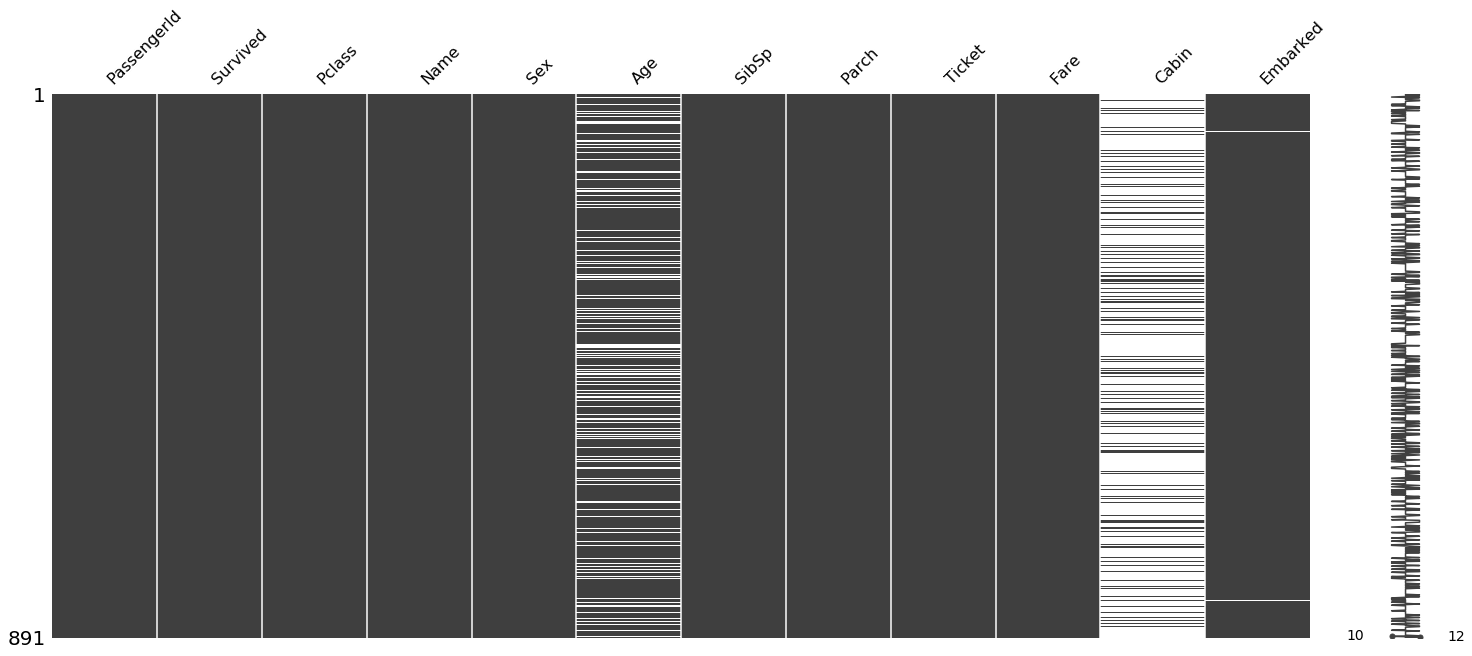

In [94]:
msno.matrix(train)

In [95]:
## 欠損値の数と割合を返す
def missing_columns(df):
    total = df.isnull().sum().sort_values(ascending = False)
    percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
    missing_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data

In [96]:
missing_columns(train)

,Total,Percent
Cabin,687,77.104377
Age,177,19.865320
Embarked,2,0.224467
Fare,0,0.000000
Ticket,0,0.000000
Parch,0,0.000000
SibSp,0,0.000000
Sex,0,0.000000
Name,0,0.000000
Pclass,0,0.000000


In [97]:
missing_columns(test)

,Total,Percent
Cabin,327,78.229665
Age,86,20.574163
Fare,1,0.239234
Embarked,0,0.000000
Ticket,0,0.000000
Parch,0,0.000000
SibSp,0,0.000000
Sex,0,0.000000
Name,0,0.000000
Pclass,0,0.000000


In [98]:
#Cabinは欠損値が多すぎる、PassengerId, Nameは関係ない、Ticketはよくわからないので特徴削除
#Cabin, Nameも使う
train = train.drop(columns=['PassengerId', 'Ticket'])
test = test.drop(columns=['PassengerId', 'Ticket'])

In [99]:
#Nameを頭の文字で処理
title = [train]
for train in title: 
        train['Title'] = train.Name.str.extract(' ([A-Za-z]+).', expand=False) 
for train in title: 
        train['Title'] = train['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
        train['Title'] = train['Title'].replace('Mlle', 'Miss')
        train['Title'] = train['Title'].replace('Ms', 'Miss')
        train['Title'] = train['Title'].replace('Mme', 'Mrs')
        del train['Name']
SalutationMapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5} 
for train in title: 
        train['Title'] = train['Title'].map(SalutationMapping) 
        train['Title'] = train['Title'].fillna(0)

title = [test]
for test in title: 
        test['Title'] = test.Name.str.extract(' ([A-Za-z]+).', expand=False) 
for test in title: 
        test['Title'] = test['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
        test['Title'] = test['Title'].replace('Mlle', 'Miss')
        test['Title'] = test['Title'].replace('Ms', 'Miss')
        test['Title'] = test['Title'].replace('Mme', 'Mrs')
        del test['Name']
SalutationMapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5} 
for test in title: 
        test['Title'] = test['Title'].map(SalutationMapping) 
        test['Title'] = test['Title'].fillna(0)

In [100]:
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title
0,0,3,male,22.0,1,0,7.2500,NaN,S,1.0
1,1,1,female,38.0,1,0,71.2833,C85,C,3.0
2,1,3,female,26.0,0,0,7.9250,NaN,S,2.0
3,1,1,female,35.0,1,0,53.1000,C123,S,3.0
4,0,3,male,35.0,0,0,8.0500,NaN,S,1.0


In [101]:
pd.value_counts(train['Embarked'])

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [102]:
#最頻値代入
train["Embarked"] = train["Embarked"].fillna("S")

In [103]:
#カテゴリ変数の変換
LE=LabelEncoder()

labels = ['Embarked','Sex']
for label in labels:
    train[label]=LE.fit_transform(train[label])
    test[label]=LE.fit_transform(test[label])

In [104]:
#Cabinの最後の数字(str)を抜き出して奇数と偶数でラベル化、最初の文字から階層もラベル化
train["RoomLorR"] = train["Cabin"].str[-1:]
test["RoomLorR"] = test["Cabin"].str[-1:]
train["RoomLayer"] = train["Cabin"].str[0]
test["RoomLayer"] = test["Cabin"].str[0]
train = train.drop(columns=["Cabin"])
test = test.drop(columns=["Cabin"])

In [105]:
train.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,RoomLorR,RoomLayer
0,0,3,1,22.0,1,0,7.2500,2,1.0,NaN,NaN
1,1,1,0,38.0,1,0,71.2833,0,3.0,5,C
2,1,3,0,26.0,0,0,7.9250,2,2.0,NaN,NaN
3,1,1,0,35.0,1,0,53.1000,2,3.0,3,C
4,0,3,1,35.0,0,0,8.0500,2,1.0,NaN,NaN
5,0,3,1,NaN,0,0,8.4583,1,1.0,NaN,NaN
6,0,1,1,54.0,0,0,51.8625,2,1.0,6,E
7,0,3,1,2.0,3,1,21.0750,2,4.0,NaN,NaN
8,1,3,0,27.0,0,2,11.1333,2,3.0,NaN,NaN
9,1,2,0,14.0,1,0,30.0708,0,3.0,NaN,NaN


In [106]:
def roomLRLabels(x):
    if (x == "1") or (x == "3") or (x == "5") or (x == "7") or (x == "9"):
        return 0
    elif (x == "0") or (x == "2") or (x == "4") or (x == "6") or (x == "8"):
        return 1

train["RoomLorR"] = train["RoomLorR"].apply(roomLRLabels)
test["RoomLorR"] = test["RoomLorR"].apply(roomLRLabels)

In [107]:
def roomLayerLabels(x):
    if x == "A":
        return 0
    elif x == "B":
        return 1
    elif x == "C":
        return 2
    elif x == "D":
        return 3
    elif x == "E":
        return 4
    elif x == "F":
        return 5
    elif x == "G":
        return 6

train["RoomLayer"] = train["RoomLayer"].apply(roomLayerLabels)
test["RoomLayer"] = test["RoomLayer"].apply(roomLayerLabels)

In [108]:
#NaNにはNaN用の値を代入
train["RoomLorR"] = train["RoomLorR"].fillna(2)
test["RoomLorR"] = test["RoomLorR"].fillna(2)
train["RoomLayer"] = train["RoomLayer"].fillna(7)
test["RoomLayer"] = test["RoomLayer"].fillna(7)

In [109]:
train.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,RoomLorR,RoomLayer
0,0,3,1,22.0,1,0,7.2500,2,1.0,2.0,7.0
1,1,1,0,38.0,1,0,71.2833,0,3.0,0.0,2.0
2,1,3,0,26.0,0,0,7.9250,2,2.0,2.0,7.0
3,1,1,0,35.0,1,0,53.1000,2,3.0,0.0,2.0
4,0,3,1,35.0,0,0,8.0500,2,1.0,2.0,7.0
5,0,3,1,NaN,0,0,8.4583,1,1.0,2.0,7.0
6,0,1,1,54.0,0,0,51.8625,2,1.0,1.0,4.0
7,0,3,1,2.0,3,1,21.0750,2,4.0,2.0,7.0
8,1,3,0,27.0,0,2,11.1333,2,3.0,2.0,7.0
9,1,2,0,14.0,1,0,30.0708,0,3.0,2.0,7.0


In [110]:
missing_columns(train)

,Total,Percent
Age,177,19.86532
RoomLayer,0,0.00000
RoomLorR,0,0.00000
Title,0,0.00000
Embarked,0,0.00000
Fare,0,0.00000
Parch,0,0.00000
SibSp,0,0.00000
Sex,0,0.00000
Pclass,0,0.00000


In [111]:
missing_columns(test)

,Total,Percent
Age,86,20.574163
Fare,1,0.239234
RoomLayer,0,0.000000
RoomLorR,0,0.000000
Title,0,0.000000
Embarked,0,0.000000
Parch,0,0.000000
SibSp,0,0.000000
Sex,0,0.000000
Pclass,0,0.000000


In [112]:
pd.value_counts(train['RoomLorR'])

2.0    691
1.0    110
0.0     90
Name: RoomLorR, dtype: int64

In [113]:
#Ageをカテゴライズ
def age(x):
    if (0 <= x) and (x < 10):
        return 0
    elif (10 <= x) and (x < 20):
        return 1
    elif (20 <= x) and (x < 30):
        return 2
    elif (30 <= x) and (x < 40):
        return 3
    elif (40 <= x) and (x < 50):
        return 4
    elif (50 <= x) and (x < 60):
        return 5
    elif (60 <= x) and (x < 70):
        return 6
    elif (70 <= x) and (x <= 80):
        return 7

In [114]:
train["aboutAge"] = train["Age"].apply(age)
test["aboutAge"] = test["Age"].apply(age)
train = train.drop(columns=["Age"])
test = test.drop(columns=["Age"])

In [115]:
#Fareをカテゴライズ
def fare(x):
    if (0.0 <= x) and (x < 50.0):
        return 0
    elif (50.0 <= x) and (x < 100.0):
        return 1
    elif (100.0 <= x) and (x < 150.0):
        return 2
    elif (150.0 <= x) and (x < 200.0):
        return 3
    elif (200.0 <= x) and (x < 250.0):
        return 4
    elif (250.0 <= x) and (x < 300.0):
        return 5
    elif (300.0 <= x) and (x < 350.0):
        return 6
    elif (350.0 <= x) and (x < 400.0):
        return 7
    elif (400.0 <= x) and (x < 450.0):
        return 8
    elif (450.0 <= x) and (x < 500.0):
        return 9
    elif (500.0 <= x):
        return 10

In [116]:
#train["aboutFare"] = train["Fare"].apply(age)
#test["aboutFare"] = test["Fare"].apply(age)
#train = train.drop(columns=["Fare"])
#test = test.drop(columns=["Fare"])

In [117]:
train.head()

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked,Title,RoomLorR,RoomLayer,aboutAge
0,0,3,1,1,0,7.2500,2,1.0,2.0,7.0,2.0
1,1,1,0,1,0,71.2833,0,3.0,0.0,2.0,3.0
2,1,3,0,0,0,7.9250,2,2.0,2.0,7.0,2.0
3,1,1,0,1,0,53.1000,2,3.0,0.0,2.0,3.0
4,0,3,1,0,0,8.0500,2,1.0,2.0,7.0,3.0


In [118]:
train = train.fillna(train.mean()) # 平均値代入
test = test.fillna(test.mean()) # 平均値代入

In [119]:
missing_columns(train)

,Total,Percent
aboutAge,0,0.0
RoomLayer,0,0.0
RoomLorR,0,0.0
Title,0,0.0
Embarked,0,0.0
Fare,0,0.0
Parch,0,0.0
SibSp,0,0.0
Sex,0,0.0
Pclass,0,0.0


In [120]:
train["SibSpParch"] = train["SibSp"] + train["Parch"]
test["SibSpParch"] = test["SibSp"] + test["Parch"]
train = train.drop(columns=["SibSp", "Parch"])
test = test.drop(columns=["SibSp", "Parch"])

([array([ 80.,   0.,  97.,   0., 372.]),
  array([216.,   0., 184.,   0., 491.])],
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. ]),
 <a list of 2 Lists of Patches objects>)

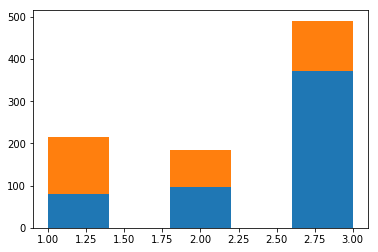

In [121]:
split_data = []
for survived in [0,1]:
    split_data.append(train[train.Survived==survived])

temp = [i["Pclass"].dropna() for i in split_data]
plt.hist(temp, histtype="barstacked", bins=5)

([array([ 24.,   0.,  61.,   0., 143., 125.,  94.,   0.,  55.,   0.,  28.,
           0.,  13.,   6.]),
  array([ 62.,   0., 102.,   0., 220., 177., 167.,   0.,  89.,   0.,  48.,
           0.,  19.,   7.])],
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ,
        6.5, 7. ]),
 <a list of 2 Lists of Patches objects>)

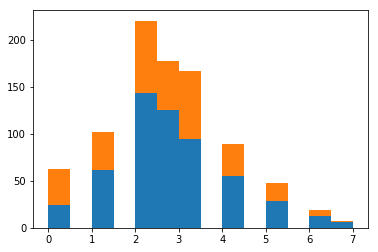

In [122]:
#欠損値は平均値で補った関係で20代後半が突出
temp = [i["aboutAge"].dropna() for i in split_data]
plt.hist(temp, histtype="barstacked", bins=14)

([array([ 81.,   0., 468.]), array([314.,   0., 577.])],
 array([0.        , 0.33333333, 0.66666667, 1.        ]),
 <a list of 2 Lists of Patches objects>)

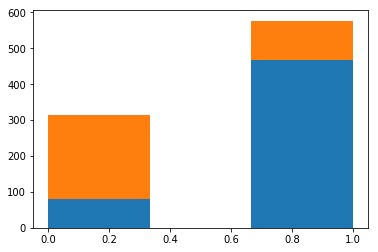

In [123]:
#femaleの方が生存率が高い
temp = [i["Sex"].dropna() for i in split_data]
plt.hist(temp, histtype="barstacked", bins=3)

In [124]:
#temp = [i["SibSp"].dropna() for i in split_data]
#plt.hist(temp, histtype="barstacked", bins=16)

In [125]:
#temp = [i["Parch"].dropna() for i in split_data]
#plt.hist(temp, histtype="barstacked", bins=12)

([array([374.,  72.,  43.,   8.,  12.,  19.,   8.,   6.,   0.,   7.]),
  array([537., 161., 102.,  29.,  15.,  22.,  12.,   6.,   0.,   7.])],
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <a list of 2 Lists of Patches objects>)

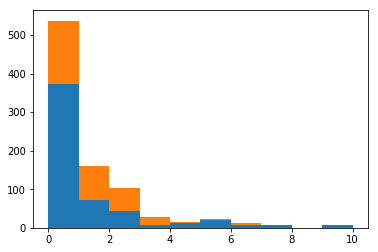

In [126]:
temp = [i["SibSpParch"].dropna() for i in split_data]
plt.hist(temp, histtype="barstacked", bins=10)

([array([ 75.,   0.,  47.,   0., 427.]),
  array([168.,   0.,  77.,   0., 646.])],
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. ]),
 <a list of 2 Lists of Patches objects>)

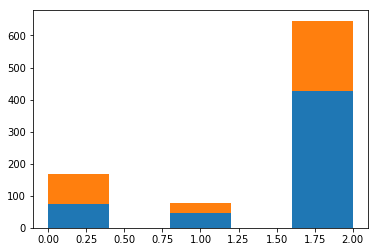

In [127]:
temp = [i["Embarked"].dropna() for i in split_data]
plt.hist(temp, histtype="barstacked", bins=5)

([array([ 24.,   0.,  42.,   0., 483.]),
  array([ 90.,   0., 110.,   0., 691.])],
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. ]),
 <a list of 2 Lists of Patches objects>)

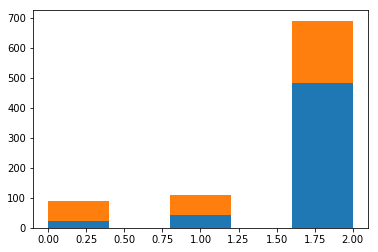

In [128]:
temp = [i["RoomLorR"].dropna() for i in split_data]
plt.hist(temp, histtype="barstacked", bins=5)

([array([  8.,  12.,  24.,   8.,   8.,   5.,   2., 482.]),
  array([ 15.,  47.,  59.,  33.,  32.,  13.,   4., 688.])],
 array([0.   , 0.875, 1.75 , 2.625, 3.5  , 4.375, 5.25 , 6.125, 7.   ]),
 <a list of 2 Lists of Patches objects>)

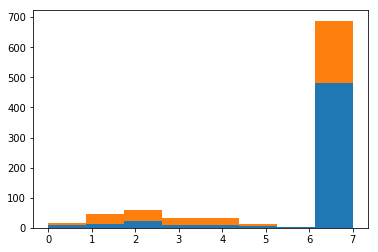

In [129]:
temp = [i["RoomLayer"].dropna() for i in split_data]
plt.hist(temp, histtype="barstacked", bins=8)

([array([499.,  36.,   8.,   0.,   4.,   2.,   0.,   0.,   0.,   0.]),
  array([732., 106.,  31.,   2.,  11.,   6.,   0.,   0.,   0.,   3.])],
 array([  0.     ,  51.23292, 102.46584, 153.69876, 204.93168, 256.1646 ,
        307.39752, 358.63044, 409.86336, 461.09628, 512.3292 ]),
 <a list of 2 Lists of Patches objects>)

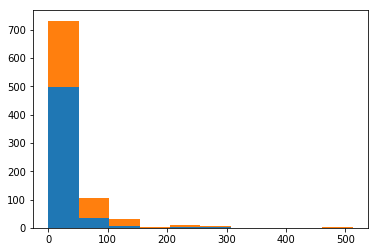

In [130]:
temp = [i["Fare"].dropna() for i in split_data]
plt.hist(temp, histtype="barstacked", bins=10)

([array([ 17., 423.,  53.,  24.,  17.,  15.]),
  array([ 25., 502., 182., 122.,  40.,  20.])],
 array([0.        , 0.83333333, 1.66666667, 2.5       , 3.33333333,
        4.16666667, 5.        ]),
 <a list of 2 Lists of Patches objects>)

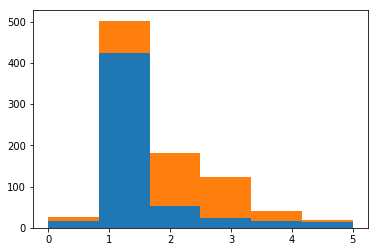

In [131]:
temp = [i["Title"].dropna() for i in split_data]
plt.hist(temp, histtype="barstacked", bins=6)

In [132]:
#dataを間引く
train = train.drop(columns=["RoomLorR", "Embarked", "RoomLayer"])
test = test.drop(columns=["RoomLorR", "Embarked", "RoomLayer"])

In [133]:
#train data と test data をそれぞれ特徴量とラベルに分ける
from sklearn.model_selection import train_test_split
trainFeatures = train.drop(columns='Survived')
trainLabels = train.Survived

In [134]:
#データ分割
X_train, X_test, y_train, y_test = train_test_split(trainFeatures, trainLabels, test_size=0.2, random_state=72)

In [48]:
#random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (roc_curve, auc, accuracy_score)

clf = RandomForestClassifier(random_state=0,
                             max_depth=10,
                             n_estimators=20,
                             )
clf = clf.fit(X_train, y_train)
pred = clf.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, pred, pos_label=1)
print(auc(fpr, tpr))
print(accuracy_score(pred, y_test))

0.8720794392523364
0.8715083798882681


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

features = X_train.columns
importance = clf.feature_importances_
indices = np.argsort(importance)

plt.figure(figsize=(6,6))
plt.barh(range(len(indices)), importance[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.show()

In [49]:
#予測用randomForest
forest = RandomForestClassifier(
    max_depth = 10,
    n_estimators = 20,
    random_state = 0)

forest = forest.fit(trainFeatures, trainLabels)

rfPred = np.round(forest.predict(test)).astype(int)

In [51]:
# テスト値を再読み込みして，randomForestでクラス分類したカラムを追加
df_out = pd.read_csv("./data/test.csv")
testLabels = pd.Series(rfPred)
df_out["Survived"] = testLabels

# outputディレクトリに出力する
df_out[["PassengerId","Survived"]].to_csv("./data/rfSubmission12.csv",index=False)

In [ ]:
X_train.head()

In [ ]:
#random forest をgrid searchでパラメータチューニング
from sklearn.model_selection import GridSearchCV

# グリッドサーチ(パラメータ候補指定)用のパラメータ10種
paramG = {'n_estimators':list(range(1, 66, 5)),
          'max_depth':list(range(1, 26, 5))
         }

#モデル生成
grid = GridSearchCV(estimator=RandomForestClassifier(random_state=0),
                    param_grid=paramG,
                    scoring='r2',
                    cv=3,
                    verbose=10,
                    n_jobs=-1)
#学習
grid = grid.fit(X_train, y_train)
#予測
pred = grid.predict(X_test)
#結果
fpr, tpr, thresholds = roc_curve(y_test, pred, pos_label=1)
print(auc(fpr, tpr))
print(accuracy_score(pred, y_test))
grid.best_params_

In [135]:
#モデル用dataset生成
import lightgbm as lgb
lgbTrain = lgb.Dataset(X_train, y_train)
lgbTest = lgb.Dataset(X_test, y_test)
lgbFinalTrain = lgb.Dataset(trainFeatures, trainLabels)

In [136]:
#light gbm

lgbParams = {
    'boosting': 'dart',          # dart (drop out trees) often performs better
    'application': 'binary',     # Binary classification
    'learning_rate': 0.01,      # Learning rate, controls size of a gradient descent step
    'max_data_in_leaf': 20,
#    'min_data_in_leaf': 10,      # Data set is quite small so reduce this a bit
    'feature_fraction': 0.6,     # Proportion of features in each boost, controls overfitting
    'num_leaves': 21,            # Controls size of tree since LGBM uses leaf wise splits
    'metric': 'binary_logloss',  # Area under ROC curve as the evaulation metric
    'drop_rate': 0.15
}

#学習
evaluationResults = {}
lgbModel = lgb.train(train_set=lgbTrain,
                     params=lgbParams,
                     valid_sets=[lgbTrain, lgbTest], 
                     valid_names=['Train', 'Test'],
                     evals_result=evaluationResults,
                     num_boost_round=5000,
                     early_stopping_rounds=500,
                     verbose_eval=40
                    )

optimum_boost_rounds = lgbModel.best_iteration

Training until validation scores don't improve for 500 rounds.
[40]	Train's binary_logloss: 0.580211	Test's binary_logloss: 0.588558
[80]	Train's binary_logloss: 0.561135	Test's binary_logloss: 0.569476
[120]	Train's binary_logloss: 0.551682	Test's binary_logloss: 0.558442
[160]	Train's binary_logloss: 0.54644	Test's binary_logloss: 0.553402
[200]	Train's binary_logloss: 0.51548	Test's binary_logloss: 0.524518
[240]	Train's binary_logloss: 0.497468	Test's binary_logloss: 0.507276
[280]	Train's binary_logloss: 0.482836	Test's binary_logloss: 0.494077
[320]	Train's binary_logloss: 0.473615	Test's binary_logloss: 0.48601
[360]	Train's binary_logloss: 0.475389	Test's binary_logloss: 0.487509
[400]	Train's binary_logloss: 0.465313	Test's binary_logloss: 0.478139
[440]	Train's binary_logloss: 0.453565	Test's binary_logloss: 0.467041
[480]	Train's binary_logloss: 0.438261	Test's binary_logloss: 0.4535
[520]	Train's binary_logloss: 0.428462	Test's binary_logloss: 0.44535
[560]	Train's binary_l

In [137]:
#from sklearn.ensemble import GradientBoostingClassifier #GBM algorithm
#from sklearn.grid_search import GridSearchCV #Perforing grid search

#param_test3 = {'min_samples_leaf':list(range(30,71,10))}
#gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60, min_samples_split=800, max_depth=7,max_features='sqrt', subsample=0.8, random_state=10), 
#param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
#gsearch3.fit(trainFeatures,trainLabels)
#mean_list = []
#for s in gsearch3.grid_scores_:
#    mean_list.append(s[1])
#plt.figure(figsize=(4,2))
#plt.plot(list(range(30,71,10)), mean_list)
#plt.title("GridSearchCV Score")
#plt.xlabel("min_samples_leaf")
#plt.show()
#gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

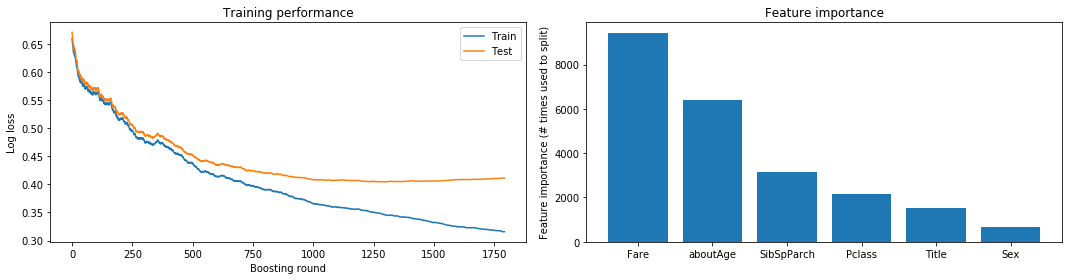

In [138]:
fig, axs = plt.subplots(1, 2, figsize=[15, 4])

# Plot the log loss during training
axs[0].plot(evaluationResults['Train']['binary_logloss'], label='Train')
axs[0].plot(evaluationResults['Test']['binary_logloss'], label='Test')
axs[0].set_ylabel('Log loss')
axs[0].set_xlabel('Boosting round')
axs[0].set_title('Training performance')
axs[0].legend()

# Plot feature importance
importances = pd.DataFrame({'features': lgbModel.feature_name(), 
                            'importance': lgbModel.feature_importance()}).sort_values('importance', ascending=False)
axs[1].bar(x=np.arange(len(importances)), height=importances['importance'])
axs[1].set_xticks(np.arange(len(importances)))
axs[1].set_xticklabels(importances['features'])
axs[1].set_ylabel('Feature importance (# times used to split)')
axs[1].set_title('Feature importance')

plt.tight_layout()
plt.show()

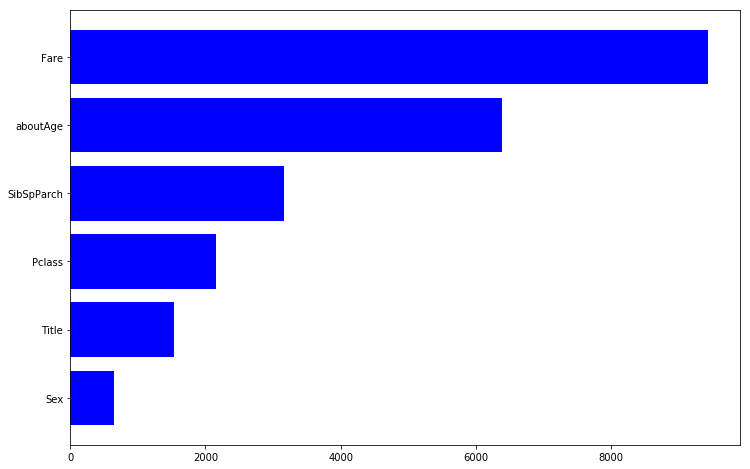

In [139]:
features = X_train.columns
importance = lgbModel.feature_importance()
indices = np.argsort(importance)

plt.figure(figsize=(12,8))
plt.barh(range(len(indices)), importance[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.show()

In [140]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
preds = np.round(lgbModel.predict(X_test))
print('Accuracy score = \t {}'.format(accuracy_score(y_test, preds)))
print('Precision score = \t {}'.format(precision_score(y_test, preds)))
print('Recall score =   \t {}'.format(recall_score(y_test, preds)))
print('F1 score =      \t {}'.format(f1_score(y_test, preds)))

Accuracy score = 	 0.8659217877094972
Precision score = 	 0.8333333333333334
Recall score =   	 0.8333333333333334
F1 score =      	 0.8333333333333334


In [141]:
#予測用datasetで予測
lgbFinal = lgb.train(train_set=lgbFinalTrain,
                      params=lgbParams,
                      num_boost_round=optimum_boost_rounds,
                      verbose_eval=0
                      )

lgbPred = np.round(lgbFinal.predict(test)).astype(int)

In [142]:
# テスト値を再読み込みして，randomForestでクラス分類したカラムを追加
df_out = pd.read_csv("./data/test.csv")
testLabels = pd.Series(lgbPred)
df_out["Survived"] = testLabels

# outputディレクトリに出力する
#df_out[["PassengerId","Survived"]].to_csv("./data/lgbSubmission5.csv",index=False)

In [143]:
#予測結果でラベル付けしたtest dataを追加して再度学習する

In [144]:
df_out.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1


In [145]:
testFeatures = test

In [146]:
testFeatures.head()

,Pclass,Sex,Fare,Title,aboutAge,SibSpParch
0,3,1,7.8292,1.0,3.0,0
1,3,0,7.0000,3.0,4.0,1
2,2,1,9.6875,1.0,6.0,0
3,3,1,8.6625,1.0,2.0,0
4,3,0,12.2875,3.0,2.0,2


In [147]:
trainFeatures.head()

,Pclass,Sex,Fare,Title,aboutAge,SibSpParch
0,3,1,7.2500,1.0,2.0,1
1,1,0,71.2833,3.0,3.0,1
2,3,0,7.9250,2.0,2.0,0
3,1,0,53.1000,3.0,3.0,1
4,3,1,8.0500,1.0,3.0,0


In [148]:
mixDataFeatures = pd.concat([trainFeatures,testFeatures])
mixDataLabels = pd.concat([trainLabels, testLabels])

In [149]:
mixDataFeatures.shape

(1309, 6)

In [150]:
mixDataFeatures.head()

,Pclass,Sex,Fare,Title,aboutAge,SibSpParch
0,3,1,7.2500,1.0,2.0,1
1,1,0,71.2833,3.0,3.0,1
2,3,0,7.9250,2.0,2.0,0
3,1,0,53.1000,3.0,3.0,1
4,3,1,8.0500,1.0,3.0,0


In [151]:
mixDataLabels.head()

0    0
1    1
2    1
3    1
4    0
dtype: int64

In [152]:
#データ分割
X_train, X_test, y_train, y_test = train_test_split(mixDataFeatures, mixDataLabels, test_size=0.2, random_state=72)

In [ ]:
#random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (roc_curve, auc, accuracy_score)

clf = RandomForestClassifier(random_state=0,
                             max_depth=10,
                             n_estimators=20,
                             )
clf = clf.fit(X_train, y_train)
pred = clf.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, pred, pos_label=1)
print(auc(fpr, tpr))
print(accuracy_score(pred, y_test))

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

features = X_train.columns
importance = clf.feature_importances_
indices = np.argsort(importance)

plt.figure(figsize=(6,6))
plt.barh(range(len(indices)), importance[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.show()

In [ ]:
#予測用randomForest
forest = RandomForestClassifier(
    max_depth = 10,
    n_estimators = 20,
    random_state = 0)

forest = forest.fit(mixDataFeatures, mixDataLabels)

rfPred = np.round(forest.predict(test)).astype(int)

In [ ]:
# テスト値を再読み込みして，randomForestでクラス分類したカラムを追加
df_out = pd.read_csv("./data/test.csv")
testLabels = pd.Series(rfPred)
df_out["Survived"] = testLabels

# outputディレクトリに出力する
df_out[["PassengerId","Survived"]].to_csv("./data/rfSubmission12.csv",index=False)

In [153]:
#モデル用dataset生成
import lightgbm as lgb
lgbTrain = lgb.Dataset(X_train, y_train)
lgbTest = lgb.Dataset(X_test, y_test)
lgbFinalTrain = lgb.Dataset(trainFeatures, trainLabels)

In [154]:
#light gbm

lgbParams = {
    'boosting': 'dart',          # dart (drop out trees) often performs better
    'application': 'binary',     # Binary classification
    'learning_rate': 0.02,       # Learning rate, controls size of a gradient descent step
    'max_data_in_leaf': 20,      # Data set is quite small so reduce this a bit
    'feature_fraction': 0.6,     # Proportion of features in each boost, controls overfitting
    'num_leaves': 21,            # Controls size of tree since LGBM uses leaf wise splits
    'metric': 'binary_logloss',  # Area under ROC curve as the evaulation metric
    'drop_rate': 0.15
}

#学習
evaluationResults = {}
lgbModel = lgb.train(train_set=lgbTrain,
                     params=lgbParams,
                     valid_sets=[lgbTrain, lgbTest], 
                     valid_names=['Train', 'Test'],
                     evals_result=evaluationResults,
                     num_boost_round=5000,
                     early_stopping_rounds=1000,
                     verbose_eval=40
                    )

optimum_boost_rounds = lgbModel.best_iteration

Training until validation scores don't improve for 1000 rounds.
[40]	Train's binary_logloss: 0.491779	Test's binary_logloss: 0.491739
[80]	Train's binary_logloss: 0.458982	Test's binary_logloss: 0.463294
[120]	Train's binary_logloss: 0.442583	Test's binary_logloss: 0.447645
[160]	Train's binary_logloss: 0.433639	Test's binary_logloss: 0.439019
[200]	Train's binary_logloss: 0.389728	Test's binary_logloss: 0.399059
[240]	Train's binary_logloss: 0.36806	Test's binary_logloss: 0.379487
[280]	Train's binary_logloss: 0.351706	Test's binary_logloss: 0.365899
[320]	Train's binary_logloss: 0.342246	Test's binary_logloss: 0.357447
[360]	Train's binary_logloss: 0.345436	Test's binary_logloss: 0.359325
[400]	Train's binary_logloss: 0.3343	Test's binary_logloss: 0.351818
[440]	Train's binary_logloss: 0.322269	Test's binary_logloss: 0.341767
[480]	Train's binary_logloss: 0.307421	Test's binary_logloss: 0.329797
[520]	Train's binary_logloss: 0.298255	Test's binary_logloss: 0.324062
[560]	Train's bina

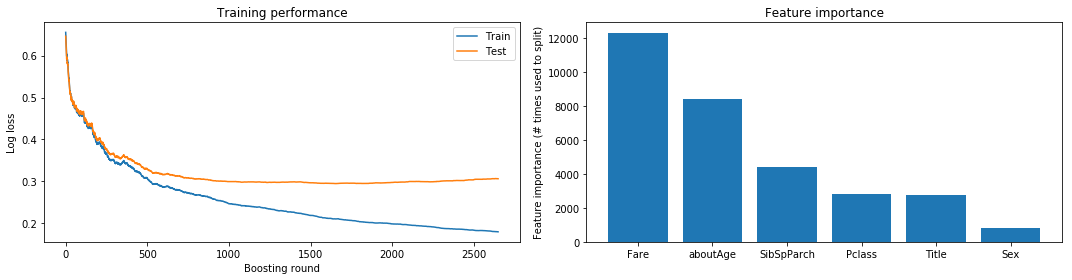

In [155]:
fig, axs = plt.subplots(1, 2, figsize=[15, 4])

# Plot the log loss during training
axs[0].plot(evaluationResults['Train']['binary_logloss'], label='Train')
axs[0].plot(evaluationResults['Test']['binary_logloss'], label='Test')
axs[0].set_ylabel('Log loss')
axs[0].set_xlabel('Boosting round')
axs[0].set_title('Training performance')
axs[0].legend()

# Plot feature importance
importances = pd.DataFrame({'features': lgbModel.feature_name(), 
                            'importance': lgbModel.feature_importance()}).sort_values('importance', ascending=False)
axs[1].bar(x=np.arange(len(importances)), height=importances['importance'])
axs[1].set_xticks(np.arange(len(importances)))
axs[1].set_xticklabels(importances['features'])
axs[1].set_ylabel('Feature importance (# times used to split)')
axs[1].set_title('Feature importance')

plt.tight_layout()
plt.show()

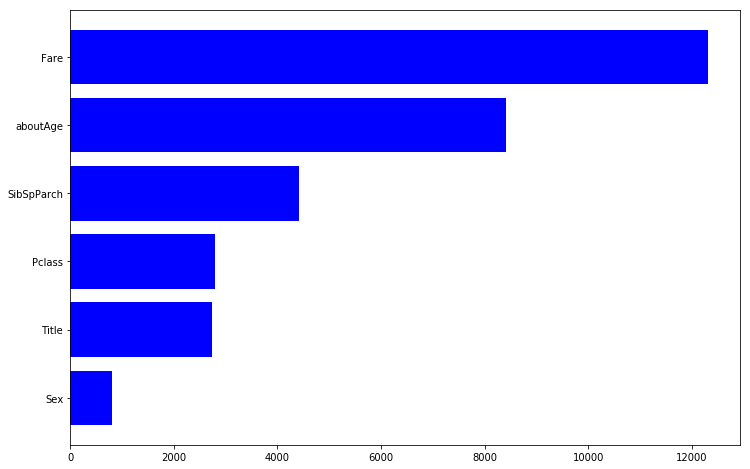

In [156]:
features = X_train.columns
importances = lgbModel.feature_importance()
indices = np.argsort(importances)

plt.figure(figsize=(12,8))
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
preds = np.round(lgbModel.predict(X_test))
print('Accuracy score = \t {}'.format(accuracy_score(y_test, preds)))
print('Precision score = \t {}'.format(precision_score(y_test, preds)))
print('Recall score =   \t {}'.format(recall_score(y_test, preds)))
print('F1 score =      \t {}'.format(f1_score(y_test, preds)))

In [ ]:
#予測用datasetで予測
lgbFinal = lgb.train(train_set=lgbFinalTrain,
                      params=lgbParams,
                      num_boost_round=optimum_boost_rounds,
                      verbose_eval=0
                      )

lgbPred = np.round(lgbFinal.predict(test)).astype(int)

In [ ]:
# テスト値を再読み込みして，randomForestでクラス分類したカラムを追加
df_out = pd.read_csv("./data/test.csv")
testLabels = pd.Series(lgbPred)
df_out["Survived"] = testLabels

# outputディレクトリに出力する
df_out[["PassengerId","Survived"]].to_csv("./data/lgbSubmission11.csv",index=False)

In [ ]:
#特徴量選択してもう一回

In [ ]:
trainCp = train
testCp = test

In [ ]:
#train data と test data をそれぞれ特徴量とラベルに分ける
trainFeatures = trainCp.drop(columns='Survived')
trainLabels = trainCp.Survived

In [ ]:
#SFSでの特徴選択
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt

knn = KNeighborsClassifier(n_neighbors=4)

sfs = SFS(knn, #学習器
          k_features=7, #特徴の最大選択数
          forward=True, #Trueでforward selection, Falseでback
          floating=False, #forward selectionの亜種を行うためのもの
          scoring='accuracy', #評価指標
          cv=5) #クロスバリデーション(cv=0とすると、最終的に選ばれる特徴が変わる)

sfs = sfs.fit(trainFeatures, trainLabels)

fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_dev')

plt.ylim([0.7, 0.9])
plt.grid()
plt.show()

In [ ]:
sfs = sfs.fit(trainFeatures, trainLabels)
sfs.subsets_

In [ ]:
#knnを使ったSFSの結果より4つの特徴を選択
trainFeatures = trainFeatures.drop(columns=['SibSp', 'Age', 'Fare'])
testCp = testCp.drop(columns=['SibSp', 'Age', 'Fare'])

In [ ]:
#相関関係より4つの特徴を選択
#trainFeatures = trainFeatures.drop(columns=['SibSp', 'Age', 'Parch'])
#testCp = testCp.drop(columns=['SibSp', 'Age', 'Parch'])

In [ ]:
trainFeatures.head()

In [ ]:
#light gbm 用データ分割
X_train, X_test, y_train, y_test = train_test_split(trainFeatures, trainLabels, test_size=0.2, random_state=72)

#モデル用dataset生成
import lightgbm as lgb
lgbTrain = lgb.Dataset(X_train, y_train)
lgbTest = lgb.Dataset(X_test, y_test)
lgbFinalTrain = lgb.Dataset(trainFeatures, trainLabels)

In [ ]:
#light gbm

lgbParams = {
    'boosting': 'dart',          # dart (drop out trees) often performs better
    'application': 'binary',     # Binary classification
    'learning_rate': 0.02,       # Learning rate, controls size of a gradient descent step
    'min_data_in_leaf': 20,      # Data set is quite small so reduce this a bit
    'feature_fraction': 0.7,     # Proportion of features in each boost, controls overfitting
    'num_leaves': 41,            # Controls size of tree since LGBM uses leaf wise splits
    'metric': 'binary_logloss',  # Area under ROC curve as the evaulation metric
    'drop_rate': 0.15
}

#学習
evaluationResults = {}
lgbModel = lgb.train(train_set=lgbTrain,
                     params=lgbParams,
                     valid_sets=[lgbTrain, lgbTest], 
                     valid_names=['Train', 'Test'],
                     evals_result=evaluationResults,
                     num_boost_round=500,
                     early_stopping_rounds=100,
                     verbose_eval=20
                    )

optimum_boost_rounds = lgbModel.best_iteration

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=[15, 4])

# Plot the log loss during training
axs[0].plot(evaluationResults['Train']['binary_logloss'], label='Train')
axs[0].plot(evaluationResults['Test']['binary_logloss'], label='Test')
axs[0].set_ylabel('Log loss')
axs[0].set_xlabel('Boosting round')
axs[0].set_title('Training performance')
axs[0].legend()

# Plot feature importance
importances = pd.DataFrame({'features': lgbModel.feature_name(), 
                            'importance': lgbModel.feature_importance()}).sort_values('importance', ascending=False)
axs[1].bar(x=np.arange(len(importances)), height=importances['importance'])
axs[1].set_xticks(np.arange(len(importances)))
axs[1].set_xticklabels(importances['features'])
axs[1].set_ylabel('Feature importance (# times used to split)')
axs[1].set_title('Feature importance')

plt.show()

In [ ]:
preds = np.round(lgbModel.predict(X_test))
print('Accuracy score = \t {}'.format(accuracy_score(y_test, preds)))
print('Precision score = \t {}'.format(precision_score(y_test, preds)))
print('Recall score =   \t {}'.format(recall_score(y_test, preds)))
print('F1 score =      \t {}'.format(f1_score(y_test, preds)))

In [ ]:
#予測用datasetで予測
lgbFinal = lgb.train(train_set=lgbFinalTrain,
                      params=lgbParams,
                      num_boost_round=optimum_boost_rounds,
                      verbose_eval=0
                      )

lgbPred = np.round(lgbFinal.predict(test)).astype(int)

In [ ]:
# テスト値を再読み込みして，randomForestでクラス分類したカラムを追加
df_out = pd.read_csv("./data/test.csv")
lgbPred = pd.Series(lgbPred)
df_out["Survived"] = lgbPred

# outputディレクトリに出力する
df_out[["PassengerId","Survived"]].to_csv("./data/lgbSubmission4.csv",index=False)

In [ ]:
#PCA
from sklearn.decomposition import PCA
import seaborn as sns

In [ ]:
sns.pairplot(trainFeatures)

In [ ]:
#次元圧縮
pca = PCA(n_components=5)
trainFeatures = pca.fit_transform(trainFeatures.values)
trainFeatures = pd.DataFrame(trainFeatures)

In [ ]:
trainFeatures.head()

In [ ]:
plt.Figure()
plt.scatter(trainFeatures[:,0], trainFeatures[:,1], trainFeatures[:,2])
plt.show()

In [ ]:
#light gbm 用データ分割
X_train, X_test, y_train, y_test = train_test_split(trainFeatures, trainLabels, test_size=0.2, random_state=72)

#モデル用dataset生成
import lightgbm as lgb
lgbTrain = lgb.Dataset(X_train, y_train)
lgbTest = lgb.Dataset(X_test, y_test)
lgbFinalTrain = lgb.Dataset(trainFeatures, trainLabels)

In [ ]:
#light gbm

lgbParams = {
    'boosting': 'dart',          # dart (drop out trees) often performs better
    'application': 'binary',     # Binary classification
    'learning_rate': 0.02,       # Learning rate, controls size of a gradient descent step
    'min_data_in_leaf': 20,      # Data set is quite small so reduce this a bit
    'feature_fraction': 0.7,     # Proportion of features in each boost, controls overfitting
    'num_leaves': 41,            # Controls size of tree since LGBM uses leaf wise splits
    'metric': 'binary_logloss',  # Area under ROC curve as the evaulation metric
    'drop_rate': 0.15
}

#学習
evaluationResults = {}
lgbModel = lgb.train(train_set=lgbTrain,
                     params=lgbParams,
                     valid_sets=[lgbTrain, lgbTest], 
                     valid_names=['Train', 'Test'],
                     evals_result=evaluationResults,
                     num_boost_round=500,
                     early_stopping_rounds=100,
                     verbose_eval=20
                    )

optimum_boost_rounds = lgbModel.best_iteration

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=[15, 4])

# Plot the log loss during training
axs[0].plot(evaluationResults['Train']['binary_logloss'], label='Train')
axs[0].plot(evaluationResults['Test']['binary_logloss'], label='Test')
axs[0].set_ylabel('Log loss')
axs[0].set_xlabel('Boosting round')
axs[0].set_title('Training performance')
axs[0].legend()

# Plot feature importance
importances = pd.DataFrame({'features': lgbModel.feature_name(), 
                            'importance': lgbModel.feature_importance()}).sort_values('importance', ascending=False)
axs[1].bar(x=np.arange(len(importances)), height=importances['importance'])
axs[1].set_xticks(np.arange(len(importances)))
axs[1].set_xticklabels(importances['features'])
axs[1].set_ylabel('Feature importance (# times used to split)')
axs[1].set_title('Feature importance')

plt.show()

In [ ]:
preds = np.round(lgbModel.predict(X_test))
print('Accuracy score = \t {}'.format(accuracy_score(y_test, preds)))
print('Precision score = \t {}'.format(precision_score(y_test, preds)))
print('Recall score =   \t {}'.format(recall_score(y_test, preds)))
print('F1 score =      \t {}'.format(f1_score(y_test, preds)))